In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight # Importation pour le calcul des poids de classe
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image


1. Prétraitement des Données et Augmentation

In [ ]:

img_height, img_width = 128, 128
batch_size = 32
num_classes = 1

"""
Prétraitement et Augmentation des Données.
ImageDataGenerator est configuré avec des transformations d'augmentation plus agressives
pour compenser la petite taille du dataset et prévenir le surapprentissage.
"""
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalise les valeurs de pixels à [0, 1]
    rotation_range=20,       # Rotations aléatoires jusqu'à 20 degrés
    width_shift_range=0.15,  # Décalages horizontaux aléatoires
    height_shift_range=0.15, # Décalages verticaux aléatoires
    shear_range=0.2,         # Transformations de cisaillement aléatoires
    zoom_range=0.2,          # Transformations de zoom aléatoires
    horizontal_flip=True,    # Retournements horizontaux aléatoires
    fill_mode='nearest'      # Stratégie de remplissage des pixels créés par les transformations
)

"""
Les données de validation et de test ne doivent pas être augmentées, seulement mises à l'échelle.
"""
val_test_datagen = ImageDataGenerator(rescale=1./255)

base_data_dir = 'chest_xray/chest_xray/' # Ajustez si nécessaire
train_dir = os.path.join(base_data_dir, 'train')
val_dir = os.path.join(base_data_dir, 'val')
test_dir = os.path.join(base_data_dir, 'test')
"""
Création des générateurs de données.
ImageDataGenerator.flow_from_directory va automatiquement détecter les classes
et assigner des indices numériques (e.g., NORMAL: 0, PNEUMONIA: 1).
"""
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Indices des classes:", train_generator.class_indices)

"""
Calcul des poids de classe pour gérer le déséquilibre du dataset.
Ceci est crucial pour que le modèle accorde plus d'attention à la classe minoritaire
pendant l'entraînement, évitant ainsi un biais vers la classe majoritaire.
Les poids sont calculés inversement proportionnellement à la fréquence de chaque classe.
"""
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Poids des classes calculés:", class_weights_dict)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Indices des classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Poids des classes calculés: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_14232\26221370.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts, palette=['green', 'red'])


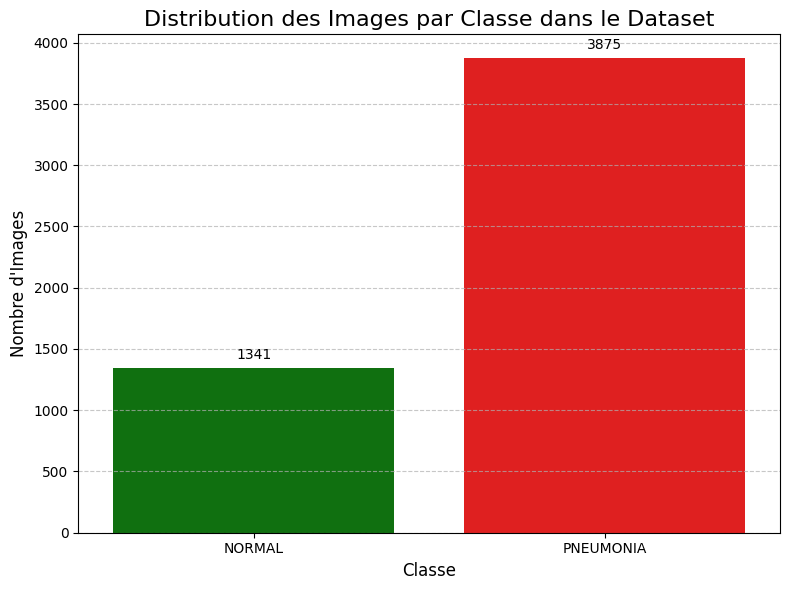

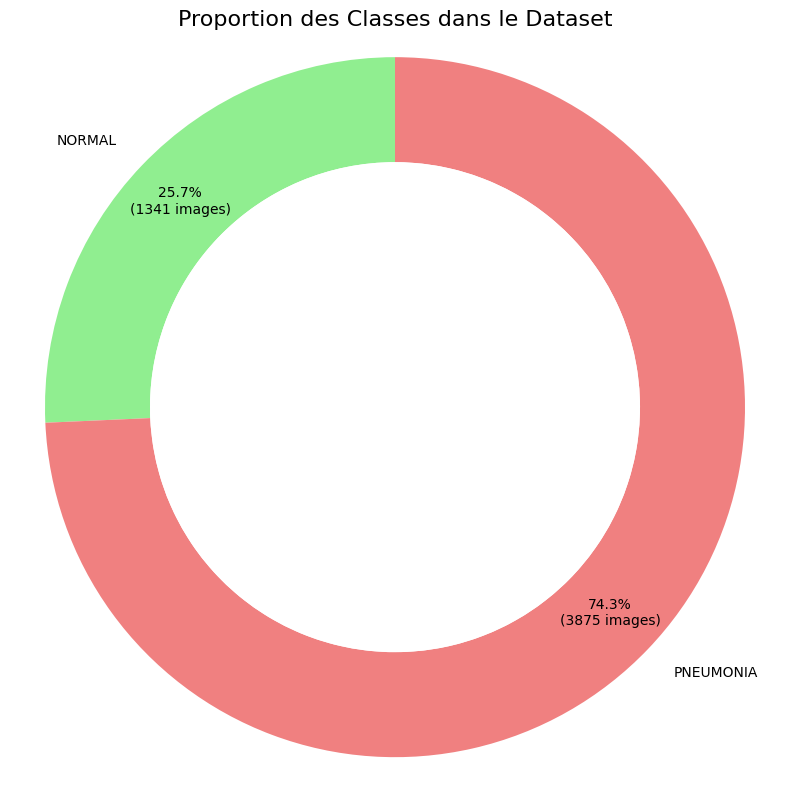

Total d'images dans le dataset: 5216
Pourcentage de NORMAL: 25.71%
Pourcentage de PNEUMONIA: 74.29%


In [ ]:



class_data = {
    "NORMAL": 1341,
    "PNEUMONIA": 3875
}

class_names = list(class_data.keys())
class_counts = list(class_data.values())
total_images = sum(class_counts)

# --- 2. Affichage du Graphique à Barres ---
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=class_counts, palette=['green', 'red'])
plt.title('Distribution des Images par Classe dans le Dataset', fontsize=16)
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Nombre d\'Images', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Afficher le nombre exact au-dessus de chaque barre
for index, value in enumerate(class_counts):
    plt.text(index, value + 50, str(value), ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 3. Affichage du Diagramme Circulaire (Camembert) ---
plt.figure(figsize=(8, 8))
# Calcul des pourcentages
percentages = [(count / total_images) * 100 for count in class_counts]

# Formatage des étiquettes pour inclure le pourcentage et le nombre
def func(pct, all_values):
    absolute = int(np.round(pct/100.*np.sum(all_values)))
    return f"{pct:.1f}%\n({absolute} images)"

plt.pie(class_counts, labels=class_names, autopct=lambda pct: func(pct, class_counts),
        colors=['lightgreen', 'lightcoral'], startangle=90, pctdistance=0.85,
        wedgeprops=dict(width=0.3)) # Donut chart style

# Ajouter un cercle au centre pour le style "donut"
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Proportion des Classes dans le Dataset', fontsize=16)
plt.axis('equal')  # Assure que le diagramme circulaire est un cercle.
plt.tight_layout()
plt.show()

print(f"Total d'images dans le dataset: {total_images}")
print(f"Pourcentage de NORMAL: {(class_data['NORMAL'] / total_images) * 100:.2f}%")
print(f"Pourcentage de PNEUMONIA: {(class_data['PNEUMONIA'] / total_images) * 100:.2f}%")

In [ ]:


print("\n--- CELLULE 3: Vérification des classes ---")
if train_generator: # Vérifier si train_generator a été initialisé
    print("Indices des classes (train_generator):", train_generator.class_indices)
    # print("Classes brutes (train_generator.classes):", train_generator.classes) # Peut être très long
    
    # Compter les occurrences de chaque classe
    # Cela aide à identifier le déséquilibre des classes
    unique_classes_train, counts_train = np.unique(train_generator.classes, return_counts=True)
    if len(unique_classes_train) == len(train_generator.class_indices):
        # Tenter de mapper les comptes aux noms de classes
        # Inverser class_indices pour mapper les index aux noms
        idx_to_class_name = {v: k for k, v in train_generator.class_indices.items()}
        class_counts_train_named = {idx_to_class_name[idx]: count for idx, count in zip(unique_classes_train, counts_train)}
        print("Nombre d'images par classe (entraînement):", class_counts_train_named)
    else:
        print("Compte des classes (entraînement, index):", dict(zip(unique_classes_train, counts_train)))

    if val_generator:
        unique_classes_val, counts_val = np.unique(val_generator.classes, return_counts=True)
        if len(unique_classes_val) == len(val_generator.class_indices):
            idx_to_class_name_val = {v: k for k, v in val_generator.class_indices.items()}
            class_counts_val_named = {idx_to_class_name_val[idx]: count for idx, count in zip(unique_classes_val, counts_val)}
            print("Nombre d'images par classe (validation):", class_counts_val_named)
        else:
            print("Compte des classes (validation, index):", dict(zip(unique_classes_val, counts_val)))
else:
    print("train_generator n'a pas été initialisé. Impossible de vérifier les classes.")


--- CELLULE 3: Vérification des classes ---
Indices des classes (train_generator): {'NORMAL': 0, 'PNEUMONIA': 1}
Nombre d'images par classe (entraînement): {'NORMAL': np.int64(1341), 'PNEUMONIA': np.int64(3875)}
Nombre d'images par classe (validation): {'NORMAL': np.int64(8), 'PNEUMONIA': np.int64(8)}


In [ ]:


# import numpy as np # Déjà importé

print("\n--- CELLULE 4: Calcul des poids de classe (ACTIVÉ) ---")

class_weight_dict = None # Initialiser
if train_generator: # S'assurer que train_generator existe et a des classes
    # Calculer les poids pour gérer le déséquilibre des classes
    classes_train = train_generator.classes
    labels_unique_train = np.unique(classes_train)
    
    if len(labels_unique_train) > 1: # S'assurer qu'il y a plus d'une classe
        class_weights_values = compute_class_weight(
            class_weight='balanced',
            classes=labels_unique_train,
            y=classes_train
        )
        # Créer un dictionnaire mappant l'index de classe au poids
        class_weight_dict = dict(zip(labels_unique_train, class_weights_values))
        print("Poids de classe calculés pour l'entraînement:", class_weight_dict)
    else:
        print("Moins de deux classes trouvées dans train_generator. Les poids de classe ne sont pas calculés.")
else:
    print("train_generator non initialisé. Impossible de calculer les poids de classe.")

# Ces class_weight_dict seront passés à model.fit() plus tard.


--- CELLULE 4: Calcul des poids de classe (ACTIVÉ) ---
Poids de classe calculés pour l'entraînement: {np.int32(0): np.float64(1.9448173005219984), np.int32(1): np.float64(0.6730322580645162)}




2. Définition du Modèle CNN

In [ ]:


print("\n--- CELLULE 5: Définition du Modèle CNN (pour un BON modèle) ---")

# Architecture CNN de base mais potentiellement améliorée
model_binary = Sequential([
    Input(shape=(img_height, img_width, 3)), # Couche d'entrée explicite

    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(), # Aide à stabiliser et accélérer l'entraînement
    MaxPooling2D((2, 2)),
    # Dropout(0.25), # Dropout après pooling peut être moins courant, parfois après activation

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)), # Ajout d'une couche
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    # Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)), # Réduit un peu par rapport à 256
    BatchNormalization(),
    Dropout(0.5), # Dropout important avant la couche de sortie
  
    Dense(num_classes, activation='sigmoid') # num_classes = 1
])

# Compilation du modèle
# Un taux d'apprentissage plus faible peut être bénéfique après quelques époques
# ou si l'entraînement est instable. Commençons par un lr un peu plus bas.
optimizer = Adam(learning_rate=1e-4) # 0.0001

model_binary.compile(optimizer=optimizer,
                     loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) # Ajout de Precision/Recall

print("Résumé du modèle amélioré :")
model_binary.summary()


--- CELLULE 5: Définition du Modèle CNN (pour un BON modèle) ---
Résumé du modèle amélioré :


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,217 (16.36 MB)

 Trainable params: 4,288,513 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("\n--- CELLULE 6: Entraînement du Modèle (pour un BON modèle) ---")

epochs = 30 # Un nombre d'époques plus raisonnable, EarlyStopping s'en chargera

history = None

if train_generator and val_generator and model_binary: # S'assurer que tout est prêt
    if train_generator.samples == 0 or val_generator.samples == 0:
        print("ERREUR: Générateurs vides. Entraînement annulé.")
    else:
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss', # Métrique à surveiller
            patience=7,         # Nombre d'époques sans amélioration avant d'arrêter
            verbose=1,
            restore_best_weights=True # Restaurer les poids du meilleur epoch
        )

        model_checkpoint = ModelCheckpoint(
            'best_chest_xray_model.keras', # Sauvegarder le meilleur modèle au format Keras natif
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # Réduire lr par un facteur de 5
            patience=1, # Si val_loss ne s'améliore pas pendant 3 époques
            verbose=1,
            min_lr=1e-6 # Taux d'apprentissage minimum
        )

        callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

        print(f"\nDébut de l'entraînement pour {epochs} époques (avec EarlyStopping)...")
        history = model_binary.fit(
            train_generator,
            steps_per_epoch=max(1, train_generator.samples // batch_size),
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=max(1, val_generator.samples // batch_size),
            class_weight=class_weight_dict if class_weight_dict else None, # UTILISATION DES POIDS DE CLASSE
            callbacks=callbacks_list
        )
        
        # La sauvegarde se fait via ModelCheckpoint, mais on peut sauvegarder le modèle final aussi
        # model_binary.save('final_chest_xray_model.keras')
        print("\nEntraînement terminé.")
else:
    print("Prérequis non remplis (générateurs ou modèle). L'entraînement est annulé.")


--- CELLULE 6: Entraînement du Modèle (pour un BON modèle) ---

Début de l'entraînement pour 30 époques (avec EarlyStopping)...
Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8037 - loss: 0.7734 - precision_1: 0.9755 - recall_1: 0.7549
Epoch 1: val_loss improved from inf to 3.87904, saving model to best_chest_xray_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.8037 - loss: 0.7734 - precision_1: 0.9755 - recall_1: 0.7550 - val_accuracy: 0.5000 - val_loss: 3.8790 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8471 - loss: 0.6939 - precision_1: 0.9765 - recall_1: 0.8111
Epoch 2: val_loss improved from 3.87904 to 2.04246, saving model to best_chest_xray_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.8471 - loss: 0.6939 - precision_1: 0.9765 - recall_1: 0.8111 - val_accuracy: 0.5000 - val_loss: 2.0425 - val_precision_1: 0.5000 - val_reca

4. Évaluation du Modèle

In [ ]:



# import tensorflow as tf # Déjà importé

print("\n--- CELLULE 7: Évaluation du Meilleur Modèle ---")

best_model_path = 'best_chest_xray_model.keras' # Chemin du modèle sauvegardé par ModelCheckpoint

if os.path.exists(best_model_path):
    # Charger le meilleur modèle sauvegardé
    # Il est important de passer custom_objects si vous avez des couches/fonctions personnalisées
    # Pour les métriques comme Precision/Recall, Keras les gère souvent bien,
    # mais parfois il faut les spécifier.
    try:
        loaded_model = tf.keras.models.load_model(best_model_path)
    except ValueError as e:
        print(f"Erreur lors du chargement du modèle, tentative avec custom_objects pour les métriques: {e}")
        loaded_model = tf.keras.models.load_model(
            best_model_path,
            custom_objects={
                'Precision': tf.keras.metrics.Precision,
                'Recall': tf.keras.metrics.Recall
            }
        )
    print(f"Meilleur modèle '{best_model_path}' chargé pour évaluation.")

    if test_generator:
        if test_generator.samples == 0:
            print("ERREUR: test_generator vide. Évaluation annulée.")
        else:
            print("\nÉvaluation du modèle sur l'ensemble de test:")
            eval_results = loaded_model.evaluate(
                test_generator,
                steps=max(1, test_generator.samples // batch_size),
                verbose=1
            )
            # Afficher les résultats avec les noms des métriques
            for metric_name, value in zip(loaded_model.metrics_names, eval_results):
                print(f"Test {metric_name}: {value:.4f}")

            print("\nPrédictions sur l'ensemble de test:")
            y_pred_probs = loaded_model.predict(test_generator, verbose=1)
            y_pred = (y_pred_probs > 0.5).astype(int).flatten() # Aplatir pour correspondre à y_true
            y_true = test_generator.classes # Devrait déjà être 1D

            if len(y_true) == len(y_pred) and len(y_true) > 0:
                print("\nMatrice de Confusion:")
                print(confusion_matrix(y_true, y_pred))
                
                print("\nRapport de Classification:")
                target_names = [k for k, v in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]
                print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))
            else:
                print("Problème avec les tailles de y_true/y_pred ou données de test vides.")
    else:
        print("test_generator non initialisé. Évaluation annulée.")
else:
    print(f"Le fichier du meilleur modèle '{best_model_path}' n'a pas été trouvé. "
          "Assurez-vous que l'entraînement a eu lieu et a sauvegardé un modèle.")


--- CELLULE 7: Évaluation du Meilleur Modèle ---
Meilleur modèle 'best_chest_xray_model.keras' chargé pour évaluation.

Évaluation du modèle sur l'ensemble de test:
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 619ms/step - accuracy: 0.8793 - loss: 0.6001 - precision_1: 0.5102 - recall_1: 0.5756
Test loss: 0.6278
Test compile_metrics: 0.8816

Prédictions sur l'ensemble de test:
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 510ms/step

Matrice de Confusion:
[[200  34]
 [ 39 351]]

Rapport de Classification:
              precision    recall  f1-score   support

      NORMAL       0.84      0.85      0.85       234
   PNEUMONIA       0.91      0.90      0.91       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624




--- CELLULE 8: Affichage de l'historique d'entraînement ---


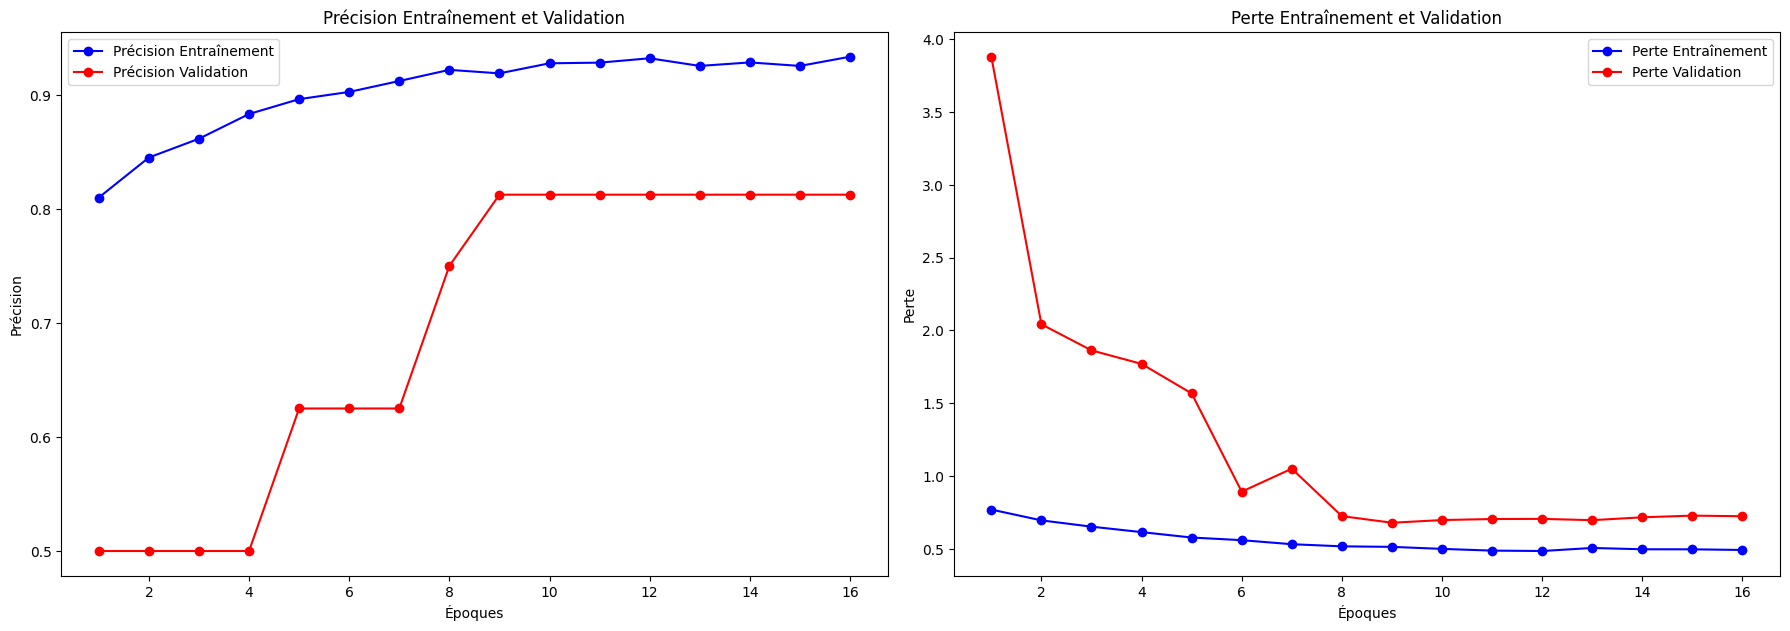

In [ ]:


print("\n--- CELLULE 8: Affichage de l'historique d'entraînement ---")

if history and history.history: # S'assurer que history existe et contient des données
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss_hist = history.history.get('loss') # Renommé pour éviter conflit
    val_loss = history.history.get('val_loss')
    
    precision_hist = history.history.get('precision') # Pour la métrique Precision
    val_precision_hist = history.history.get('val_precision')
    
    recall_hist = history.history.get('recall') # Pour la métrique Recall
    val_recall_hist = history.history.get('val_recall')

    epochs_ran = range(1, len(acc) + 1) if acc else [] # Commencer l'axe des x à 1

    if epochs_ran:
        plt.figure(figsize=(18, 12)) # Augmenter la taille pour plus de graphiques

        # Graphique de Précision
        plt.subplot(2, 2, 1)
        plt.plot(epochs_ran, acc, 'bo-', label='Précision Entraînement')
        plt.plot(epochs_ran, val_acc, 'ro-', label='Précision Validation')
        plt.title('Précision Entraînement et Validation')
        plt.xlabel('Époques')
        plt.ylabel('Précision')
        plt.legend()

        # Graphique de Perte
        plt.subplot(2, 2, 2)
        plt.plot(epochs_ran, loss_hist, 'bo-', label='Perte Entraînement')
        plt.plot(epochs_ran, val_loss, 'ro-', label='Perte Validation')
        plt.title('Perte Entraînement et Validation')
        plt.xlabel('Époques')
        plt.ylabel('Perte')
        plt.legend()

        # Graphique de Precision (métrique)
        if precision_hist and val_precision_hist:
            plt.subplot(2, 2, 3)
            plt.plot(epochs_ran, precision_hist, 'go-', label='Precision Entraînement')
            plt.plot(epochs_ran, val_precision_hist, 'mo-', label='Precision Validation')
            plt.title('Métrique Precision Entraînement et Validation')
            plt.xlabel('Époques')
            plt.ylabel('Precision')
            plt.legend()

        # Graphique de Recall (métrique)
        if recall_hist and val_recall_hist:
            plt.subplot(2, 2, 4)
            plt.plot(epochs_ran, recall_hist, 'co-', label='Recall Entraînement')
            plt.plot(epochs_ran, val_recall_hist, 'yo-', label='Recall Validation')
            plt.title('Métrique Recall Entraînement et Validation')
            plt.xlabel('Époques')
            plt.ylabel('Recall')
            plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Pas assez de données d'historique pour afficher les graphiques.")
else:
    print("L'objet 'history' n'existe pas ou est vide. L'entraînement n'a peut-être pas eu lieu.")

5. Réaliser des Prédictions sur de Nouvelles Images


--- CELLULE 9: Prédiction sur une seule image (avec le BON modèle) ---
Modèle 'best_chest_xray_model.keras' chargé pour prédiction unique.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
L'image 'IM-0001-0001.jpeg' est prédite comme: NORMAL avec une confiance de: 0.0003


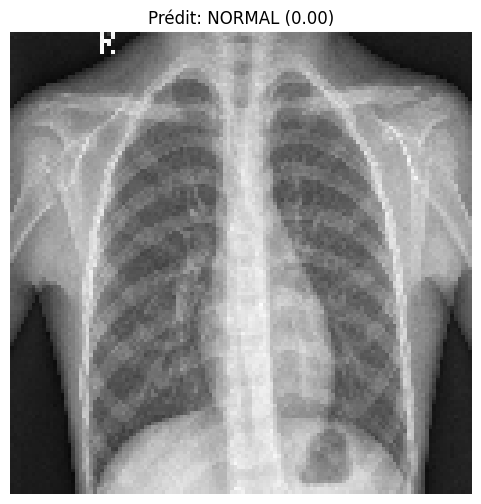

In [ ]:


 # Déjà importé via tf.keras.preprocessing
# import numpy as np # Déjà importé
# import tensorflow as tf # Déjà importé

print("\n--- CELLULE 9: Prédiction sur une seule image (avec le BON modèle) ---")

def predict_single_image_good_model(model, img_path, img_height, img_width):
    try:
        # Charge et redimensionne l'image.
        img = tf.keras.preprocessing.image.load_img(
            img_path, 
            target_size=(img_height, img_width),
            color_mode='rgb' # Doit correspondre à ce qui a été utilisé pour l'entraînement
        )
    except FileNotFoundError:
        print(f"ERREUR: Le fichier image '{img_path}' n'a pas été trouvé.")
        return "ERREUR", 0.0, None # Renvoyer None pour l'image
    except Exception as e:
        print(f"ERREUR lors du chargement de l'image '{img_path}': {e}")
        return "ERREUR", 0.0, None

    # Convertit l'image en tableau NumPy.
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Ajoute une dimension de lot (batch dimension).
    img_array_expanded = np.expand_dims(img_array, axis=0)
   
    # Normalise les pixels (ESSENTIEL - doit correspondre à l'entraînement).
    img_array_processed = img_array_expanded / 255.0

    # Prédiction
    prediction_prob = model.predict(img_array_processed)[0][0] # Accéder à la probabilité scalaire
   
    # Convertit la probabilité en une classe binaire.
    if prediction_prob > 0.5:
        predicted_label = "PNEUMONIA"
    else:
        predicted_label = "NORMAL"
        
    return predicted_label, prediction_prob, img_array # Renvoyer l'array de l'image pour affichage

# Charger le meilleur modèle entraîné.
best_model_path_single_pred = 'best_chest_xray_model.keras'

if os.path.exists(best_model_path_single_pred):
    try:
        loaded_model_single_pred = tf.keras.models.load_model(best_model_path_single_pred)
    except ValueError: # Tentative avec custom_objects si les métriques posent problème
         loaded_model_single_pred = tf.keras.models.load_model(
            best_model_path_single_pred,
            custom_objects={
                'Precision': tf.keras.metrics.Precision,
                'Recall': tf.keras.metrics.Recall
            }
        )
    print(f"Modèle '{best_model_path_single_pred}' chargé pour prédiction unique.")

    # Exemple d'utilisation :
    # Assurez-vous que ce chemin est valide ou remplacez-le.
    # Utiliser une image du set de test pour l'exemple.
    example_image_path = os.path.join(test_dir, 'NORMAL', 'IM-0001-0001.jpeg') # Exemple
    # Ou une image de pneumonie:
    # example_image_path = os.path.join(test_dir, 'PNEUMONIA', 'person1_bacteria_1.jpeg')


    if not os.path.exists(example_image_path):
        print(f"AVERTISSEMENT: L'image d'exemple '{example_image_path}' n'existe pas. "
              "La prédiction sur une seule image sera sautée ou échouera.")
        # Optionnel: créer une image factice si nécessaire pour tester le flux
        # from PIL import Image
        # if not os.path.exists(os.path.dirname(example_image_path)):
        #    os.makedirs(os.path.dirname(example_image_path))
        # Image.new('RGB', (img_width, img_height), color = 'grey').save(example_image_path)
        # print(f"Image factice créée à : {example_image_path}")


    predicted_class, confidence, img_data_for_plot = predict_single_image_good_model(
        loaded_model_single_pred,
        example_image_path,
        img_height,
        img_width
    )

    if predicted_class != "ERREUR":
        print(f"L'image '{os.path.basename(example_image_path)}' est prédite comme: {predicted_class} avec une confiance de: {confidence:.4f}")
        
        # Afficher l'image avec sa prédiction
        plt.figure(figsize=(6,6))
        # L'image est déjà normalisée si elle vient du prétraitement, sinon elle est en 0-255
        # img_data_for_plot est l'array avant normalisation pour cette fonction.
        # Si img_data_for_plot est normalisé (0-1), plt.imshow est ok.
        # S'il est en 0-255, plt.imshow est aussi ok.
        plt.imshow(img_data_for_plot.astype('uint8')) # Assurer le type correct pour l'affichage
        plt.title(f"Prédit: {predicted_class} ({confidence:.2f})")
        plt.axis('off')
        plt.show()

else:
    print(f"Le fichier du meilleur modèle '{best_model_path_single_pred}' n'a pas été trouvé pour la prédiction.")